# Altermagnetic superconductor ring

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from tqdm.notebook import tqdm

from plot_tools import complex_plot, add_tl_label
from amsc import bulk_amsc_system
from pauli import *

In [2]:
#plt.style.use("plot_style.mplstyle")

# System Setup

In [50]:
periodic_bc = True

Nx = 41
Ny = 41

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 1
t_so = 0.0
t_am = 0.0 * t

mu = 1 * t  # Midband
hz0 = 1e-9
hx0 = 0
hy0 = 0

s_imp = 0.1      # Impurity size
hx_imp = 0.0     # Impurity field
hy_imp = 0     # Impurity field
hz_imp = 0.0     # Impurity field
V_imp = +0 * t  # Impurity potential (negative = attractive)


# Fields definition
def V(x, y):
    r = np.sqrt(x**2 + y**2)
    return -mu + V_imp * np.exp(-(r**2) / s_imp**2)


def hx(x, y):
    r = np.sqrt(x**2 + y**2)
    return hx0 + hx_imp * np.exp(-(r**2) / s_imp**2)


def hy(x, y):
    r = np.sqrt(x**2 + y**2)
    return hy0 + hy_imp * np.exp(-(r**2) / s_imp**2)


def hz(x, y):
    r = np.sqrt(x**2 + y**2)
    return hz0 + hz_imp * np.exp(-(r**2) / s_imp**2)



g_mask = np.ones_like(x.flatten())

# Removing the impurity from self consistency
# g_mask[((x.flatten() == 0 )*(y.flatten() == 0))] = 0


# Temperature
T = 0.001

# Select the number of eigenvalues to calculate (it will set the energy cutoff)
N = 240

# Self consistency loops
Nloops = 0

# Sparse or dense diagonalization
sparse=True

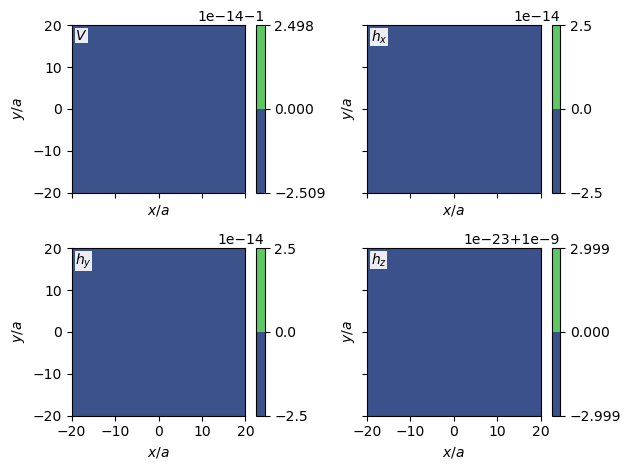

In [51]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

# Plot for V(x, y)
im1 = axs[0, 0].contourf(x, y, V(x, y))
add_tl_label(axs[0, 0], r"$V$",)
axs[0, 0].set_xlabel(r"$x/a$")
axs[0, 0].set_ylabel(r"$y/a$")

# Plot for hx(x, y)
im2 = axs[0, 1].contourf(x, y, hx(x, y))
add_tl_label(axs[0, 1], r"$h_x$")
axs[0, 1].set_xlabel(r"$x/a$")
axs[0, 1].set_ylabel(r"$y/a$")

# Plot for hy(x, y)
im3 = axs[1, 0].contourf(x, y, hy(x, y))
add_tl_label(axs[1, 0], r"$h_y$")
axs[1, 0].set_xlabel(r"$x/a$")
axs[1, 0].set_ylabel(r"$y/a$")

# Plot for hz(x, y)
im4 = axs[1, 1].contourf(x, y, hz(x, y))
add_tl_label(axs[1, 1], r"$h_z$")
axs[1, 1].set_xlabel(r"$x/a$")
axs[1, 1].set_ylabel(r"$y/a$")

fig.colorbar(im1) 
fig.colorbar(im2) 
fig.colorbar(im3) 
fig.colorbar(im4) 

fig.tight_layout()

In [52]:
# Amplitude and phase of the order parameter

## Initial value for Delta (will be used to determine g)
Delta_init = 0.4

def Delta(x, y):
    delta = Delta_init * (1 - np.exp(-np.sqrt(x**2 + y**2) / 1))
    return delta


def theta(x, y):
    return 1*np.arctan2(y, x) 

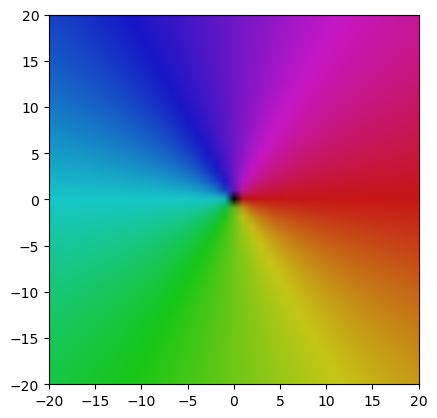

In [53]:
# Show the order parameter
fig, ax, im = complex_plot(x, y, Delta(x, y) * np.exp(1j * theta(x, y)))

In [54]:
    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )
    

In [55]:
def create_system(Delta, theta):
    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )
    
    return syst.finalized()


In [56]:
fsyst = create_system(Delta, theta)

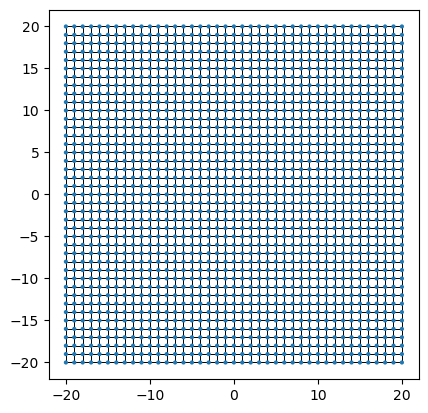

In [57]:
kwant.plot(fsyst);

In [58]:
# Quasiparticle density
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

# Electric charge
tzs0_op = kwant.operator.Density(fsyst, onsite=tzs0, sum=False)

# Spin
tzsx_op = kwant.operator.Density(fsyst, onsite=tzsx, sum=False)
tzsy_op = kwant.operator.Density(fsyst, onsite=tzsy, sum=False)
tzsz_op = kwant.operator.Density(fsyst, onsite=tzsz, sum=False)

# Singlet correlations
txs0_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
tys0_op = kwant.operator.Density(fsyst, onsite=tys0, sum=False)

# Triplet correlations
txsx_op = kwant.operator.Density(fsyst, onsite=txsx, sum=False)
tysx_op = kwant.operator.Density(fsyst, onsite=tysx, sum=False)
txsy_op = kwant.operator.Density(fsyst, onsite=txsy, sum=False)
tysy_op = kwant.operator.Density(fsyst, onsite=tysy, sum=False)
txsz_op = kwant.operator.Density(fsyst, onsite=txsz, sum=False)
tysz_op = kwant.operator.Density(fsyst, onsite=tysz, sum=False)

# Currents
j_t0s0_op = kwant.operator.Current(fsyst, onsite=t0s0)
j_tzs0_op = kwant.operator.Current(fsyst, onsite=tzs0)
j_tzsz_op = kwant.operator.Current(fsyst, onsite=tzsz)

# Exact diagonalization

## Self-consistency

We first diagonalize the system once and by comparing the triplet correlations simulated with the original delta, we deterimne
the coupling constant $g$. Then we exectue the same diagonalization and update of the order parameter for$N_\mathrm{loops}$ times keeping $g$ fixed.

In [59]:
%%time

if sparse==True:
    ws, vs = sla.eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

else:
    ws, vs = la.eigh(fsyst.hamiltonian_submatrix())
    N = 4*Nx*Ny
    
sort_idxs = np.argsort(ws)
vs = vs[:, sort_idxs]
ws = ws[sort_idxs]

CPU times: user 2min 7s, sys: 1.28 s, total: 2min 8s
Wall time: 16.6 s


In [60]:
print(f"The energy cutoff is {ws[-1]:5.3f}")

The energy cutoff is 0.450


In [61]:
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])
    
Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

g_value = Delta_init / np.mean(np.sqrt(Fx**2 + Fy**2))
g = g_value * g_mask

Delta_n = g * np.sqrt(Fx**2 + Fy**2)
theta_n = np.arctan2(Fy, Fx)

print(f"The coupling constant is {g_value:5.3f}")

The coupling constant is 3.432


In [62]:
diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
diff

0.029829983777049093

In [63]:
Delta_interp = RegularGridInterpolator((x_ax, y_ax), Delta_n.reshape(Ny, Nx))
theta_interp = RegularGridInterpolator((x_ax, y_ax), theta_n.reshape(Ny, Nx))

Delta = lambda x, y: Delta_interp((x, y))
theta = lambda x, y: theta_interp((x, y))

In [64]:
for iter_number in range(Nloops):
    # Create a new system with the new order parameter
    fsyst = create_system(
        Delta=Delta,
        theta=theta,
    )

    # Diagonalize the sytem
    ws, vs = sla.eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)
    sort_idxs = np.argsort(ws)
    vs = vs[:, sort_idxs]
    ws = ws[sort_idxs]

    # Calculate correlation functions
    txs0_ev = np.zeros((N, Nx * Ny))
    tys0_ev = np.zeros((N, Nx * Ny))
    for i in range(N):
        txs0_ev[i] = txs0_op(vs[:, i])
        tys0_ev[i] = tys0_op(vs[:, i])

    Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
    Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

    # Calculate the order parameter
    Delta_n = g * np.sqrt(Fx**2 + Fy**2)
    theta_n = np.arctan2(Fy, Fx)

    diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
    print(f"Iteration {iter_number}, the average error is: {diff:5f}")

    # Create the new interpolation functions
    Delta_interp = RegularGridInterpolator((x_ax, y_ax), Delta_n.reshape(Ny, Nx))
    theta_interp = RegularGridInterpolator((x_ax, y_ax), theta_n.reshape(Ny, Nx))

    # Update the order parameter
    Delta = lambda x, y: Delta_interp((x, y))
    theta = lambda x, y: theta_interp((x, y))

## Analysis of anomalous correlations

In [65]:
# Calculate correlation functions
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
txsx_ev = np.zeros((N, Nx * Ny))
tysx_ev = np.zeros((N, Nx * Ny))
txsy_ev = np.zeros((N, Nx * Ny))
tysy_ev = np.zeros((N, Nx * Ny))
txsz_ev = np.zeros((N, Nx * Ny))
tysz_ev = np.zeros((N, Nx * Ny))

for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])
    
    txsx_ev[i] = txsx_op(vs[:, i])
    tysx_ev[i] = tysx_op(vs[:, i])
    
    txsy_ev[i] = txsy_op(vs[:, i])
    tysy_ev[i] = tysy_op(vs[:, i])
    
    txsz_ev[i] = txsz_op(vs[:, i])
    tysz_ev[i] = tysz_op(vs[:, i])

F0_re = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
F0_im = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fx_re = np.einsum("ni, n -> i", txsx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fx_im = np.einsum("ni, n -> i", tysx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fy_re = np.einsum("ni, n -> i", txsy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fy_im = np.einsum("ni, n -> i", tysy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fz_re = np.einsum("ni, n -> i", txsz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)
Fz_im = np.einsum("ni, n -> i", tysz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny)

F0_abs = np.sqrt(F0_re**2 + F0_im**2)
F0_theta = np.arctan2(F0_im, F0_re)
Fx_abs = np.sqrt(Fx_re**2 + Fx_im**2)
Fx_theta = np.arctan2(Fx_im, Fx_re)
Fy_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fy_theta = np.arctan2(Fy_im, Fy_re)
Fz_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fz_theta = np.arctan2(Fy_im, Fy_re)

In [66]:
F0_abs.max()

0.26178223550593754

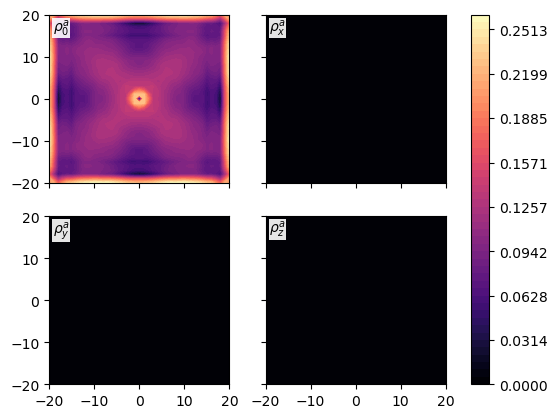

In [67]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
im00 = axs[0, 0].contourf(x, y, F0_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[0, 1].contourf(x, y, Fx_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[1, 0].contourf(x, y, Fy_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())
axs[1, 1].contourf(x, y, Fz_abs, cmap="magma", levels=np.linspace(0, 1, 51)*F0_abs.max())

cbar00 = fig.colorbar(im00, ax=axs, location="right")

add_tl_label(axs[0, 0], r"$\rho^a_0$")
add_tl_label(axs[0, 1], r"$\rho^a_x$")
add_tl_label(axs[1, 0], r"$\rho^a_y$")
add_tl_label(axs[1, 1], r"$\rho^a_z$")

In [68]:
 F0_abs.min()

1.601881954771548e-15

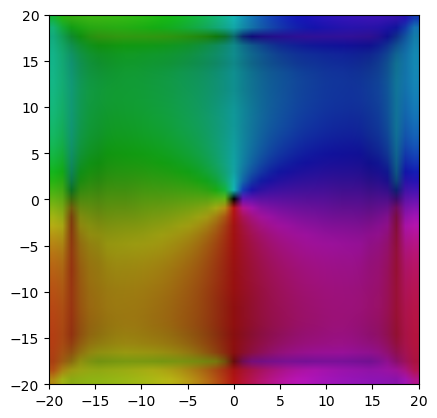

In [69]:
fig, ax, im = complex_plot(y, x, F0_abs * np.exp(1j * F0_theta))

## Single states analysis

In [70]:
# Select the subgap state to analyze
idx = len(ws) // 2

Text(0, 0.5, 'Energy')

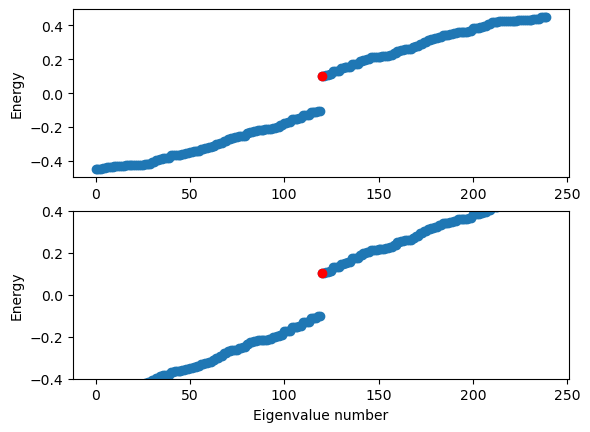

In [71]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.scatter(np.arange(len(ws)), ws)
ax1.scatter(idx, ws[idx], c="r")
ax1.set_ylabel(r"Energy")

ax2.scatter(np.arange(len(ws)), ws)
ax2.scatter(idx, ws[idx], c="r")
ax2.set_ylim(-Delta_init, Delta_init)
ax2.set_xlabel(r"Eigenvalue number")
ax2.set_ylabel(r"Energy")

In [72]:
# Calculate the densities
t0s0_d = t0s0_op(vs[:, idx])
tzs0_d = tzs0_op(vs[:, idx])
tzsz_d = tzsz_op(vs[:, idx])

txs0_d = txs0_op(vs[:, idx])
tys0_d = tys0_op(vs[:, idx])
txsx_d = txsx_op(vs[:, idx])
txsy_d = txsy_op(vs[:, idx])
txsz_d = txsz_op(vs[:, idx])
tysx_d = tysx_op(vs[:, idx])
tysy_d = tysy_op(vs[:, idx])
tysz_d = tysz_op(vs[:, idx])

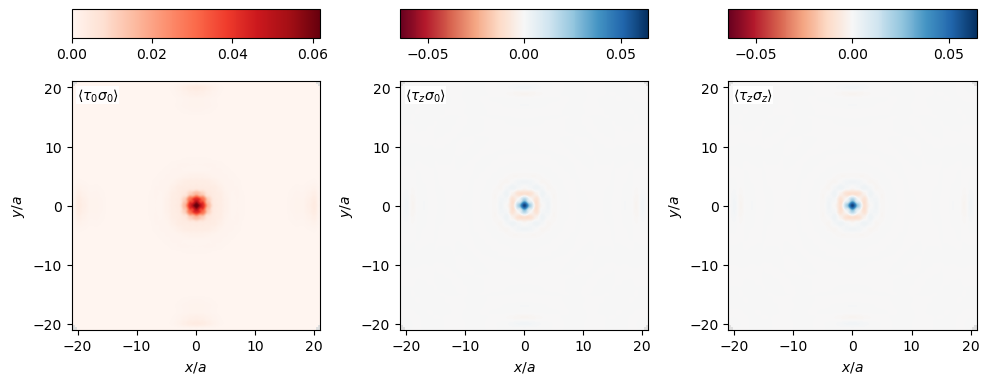

In [73]:
# Your existing code
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, t0s0_d, ax=ax1, cmap="Reds", colorbar=cax1)
im2 = kwant.plotter.density(
    fsyst, tzs0_d, ax=ax2, cmap="RdBu", vmin=-abs(tzs0_d).max(), vmax=+abs(tzs0_d).max()
)
im3 = kwant.plotter.density(
    fsyst, tzsz_d, ax=ax3, cmap="RdBu", vmin=-abs(tzsz_d).max(), vmax=+abs(tzsz_d).max()
)

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

add_tl_label(ax1, r"$\langle \tau_0 \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_z \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_z \sigma_z \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, txs0_d, ax=ax1, cmap="RdBu", colorbar=cax1)
im2 = kwant.plotter.density(fsyst, tys0_d, ax=ax2, cmap="RdBu")
im3 = kwant.plotter.density(fsyst, txsx_d, ax=ax3, cmap="RdBu")

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

# Add labels to the top-left corner of each plot

add_tl_label(ax1, r"$\langle \tau_x \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_y \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_x \sigma_x \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()


### Currents

In [ ]:
j_t0s0 = j_t0s0_op(vs[:, idx])
j_tzs0 = j_tzs0_op(vs[:, idx])
j_tzsz = j_tzsz_op(vs[:, idx])

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

im1 = kwant.plotter.current(
    fsyst, j_t0s0, ax=ax1, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im2 = kwant.plotter.current(
    fsyst, j_tzs0, ax=ax2, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im3 = kwant.plotter.current(
    fsyst, j_tzsz, ax=ax3, colorbar=True, min_linewidth=0.1, max_linewidth=2
)

ax1.set_xlim(-35, 35)
ax1.set_ylim(-35, 35)

ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(-35, 35)
ax3.set_ylim(-35, 35)

### Old code keeped only for reference

In [ ]:
# Define the matrix elements of the magnetic quadrupole moment
def qxx(site):
    x, y = site.pos
    return tzsz * x**2


def qyy(site):
    x, y = site.pos
    return tzsz * y**2


def qxy(site):
    x, y = site.pos
    return tzsz * x * y


Qxx_op = kwant.operator.Density(fsyst, qxx, sum=True)
Qyy_op = kwant.operator.Density(fsyst, qyy, sum=True)
Qxy_op = kwant.operator.Density(fsyst, qxy, sum=True)

# Calculate the magnetic quadrupole moment
q_ev = np.array(
    [[Qxx_op(vs[:, idx]), Qxy_op(vs[:, idx])], [Qxy_op(vs[:, idx]), Qyy_op(vs[:, idx])]]
)

print(q_ev)

In [ ]:
Qyy = kwant.operator.Density(fsyst, qyy, sum=True)
Qyy(vs[:, idx])

In [ ]:
Qxy = kwant.operator.Density(fsyst, qxy, sum=True)
Qxy(vs[:, idx])